In [ ]:
!pip uninstall rpy2

In [ ]:
!pip install rpy2==3.5.1
!pip install dionysus
!pip install zarr
!pip install POT
!pip install gudhi
!pip install validclust
!pip install ipython-autotime

In [ ]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA/")
!ls -ltr

In [ ]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
import gudhi as gd
import time
import math
from gudhi.wasserstein import wasserstein_distance as wd
from gudhi.representations import Landscape
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from validclust import dunn, cop, ValidClust
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
sns.set_theme()
%load_ext autotime

In [ ]:
fname2 = 'Tile_1_33'

rawFileList = os.listdir(fname2)
print (rawFileList)

In [ ]:
dfLabel = pd.read_csv(fname2 + '//' + rawFileList[0])
dfLabel['name'] = dfLabel.apply(lambda row: row.scene.split('_')[3], axis=1)
label = dfLabel.loc[dfLabel['name'] == 's20192210221197', 'fire'].iloc[0]
print (label)

In [ ]:
temp_series = rawFileList[1:]
timeSeriesName = temp_series[0:17]
print(timeSeriesName)

In [ ]:
channel7List = []
channel7Name = []
for name in timeSeriesName:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 6]) # select channel 7
    channel7List.append(channelData)
    channel7Name.append(name)
print(channel7List[0])
print (len(channel7List))

In [ ]:
fname2 = 'Tiles_2021_2022'
rawFileList = os.listdir(fname2)
print (rawFileList)
print (len(rawFileList))

In [ ]:
#fname2 = 'Tiles'
csvName = 'Fire_Labels_2020-2021.csv'
#csvName2 = 'Fire_Labels_2020-2021.csv'
dfLabel = pd.read_csv(csvName)[['fname', 'fire']]
#dfLabel2 = pd.read_csv(csvName2)[['fname', 'fire']]

#rawFileList = dfLabel['fname'].tolist()
#fireDays = dfLabel.loc[dfLabel['fire'] == 1, 'fname'].tolist()
#print (fireDays)

#noFireDays = dfLabel.loc[dfLabel['fire'] == 0, 'fname'].tolist()

#print (len(fireDays) + len(noFireDays))

label = dfLabel.loc[dfLabel['fname'] == 'Tile_1_33_20203370001177.zarr', 'fire'].iloc[0]
print (label)

In [ ]:
print (len(rawFileList))

20


In [ ]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

for name in rawFileList:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

425


In [ ]:
# plot channel 7 timeseries
fig, axs = plt.subplots(85, 5, figsize=(15, 30))

for i in range(85):
    for j in range(5):
        axs[i, j].imshow(channel7List[i* 5 + j], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 5 + j], 'fire'].iloc[0]
        axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

In [ ]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower_bound = 0, upper_bound = 8): #change upper bound!!!!!!!!!!

    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = upper_bound
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = upper_bound

    return [[birth0,death0],[birth1,death1]]

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(25, 50))

pd0_union = []
pd1_union = []
groundTruth = []
for i in range(3):
    for j in range(6):
        lower_bound = 0
        upper_bound = 3

        p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j], lower_bound = lower_bound, upper_bound = upper_bound)
        pd0_union.append(p0)
        pd1_union.append(p1)
        #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
        axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        #axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='red', label = 'Dimension 0')
        axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
        axs[i, j].axhline(y = 0.5, color='r', linestyle='--')

        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j], 'fire'].iloc[0]
        groundTruth.append(label)
        axs[i, j].title.set_text('Label {}'.format(label))
        #axs[i, j].set_xlabel('Birth')
        #axs[i, j].set_ylabel('Death')

#plt.tight_layout()
#plt.show()

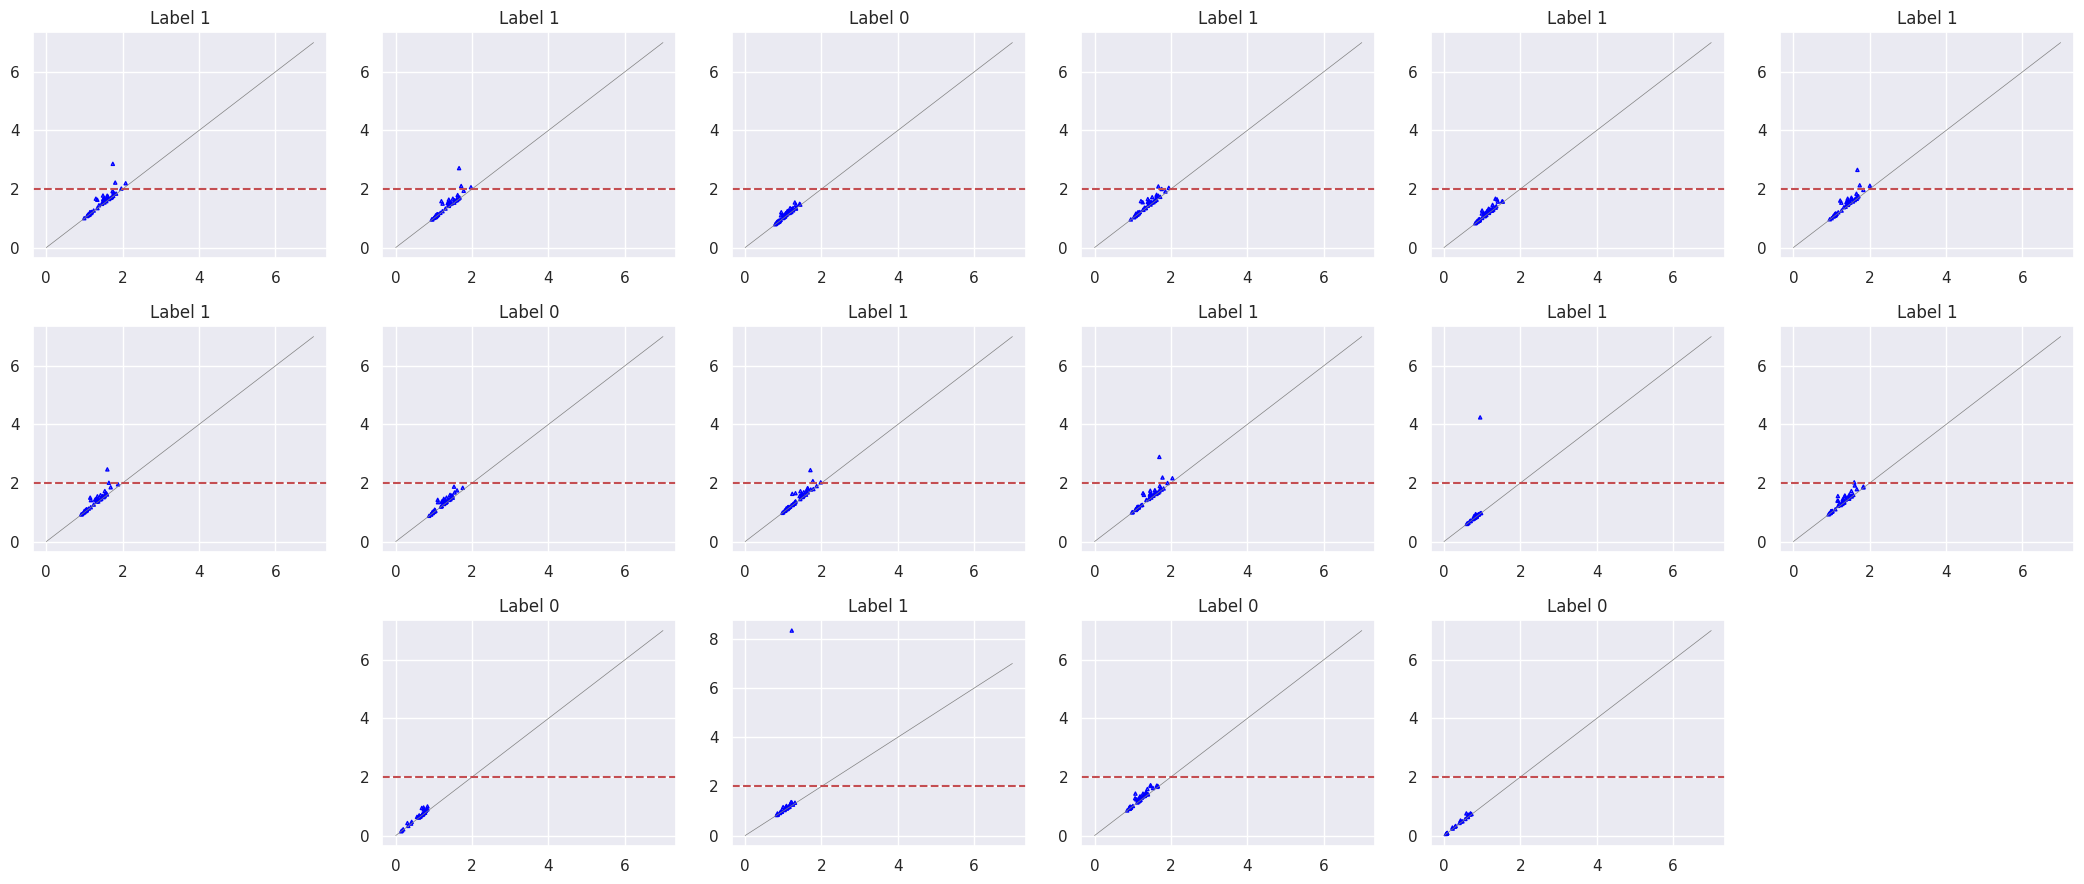

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

pd0_union = []
pd1_union = []
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            lower_bound = 0
            upper_bound = 8

            plt.tight_layout()

            p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j], lower_bound = lower_bound, upper_bound = upper_bound)
            pd0_union.append(p0)
            pd1_union.append(p1)
            #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
            axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
            axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
            #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
            axs[i, j].axhline(y = 2, color='r', linestyle='--')

            seriesStartTime = channel7Name[i* 6 + j].split('_')[3].split('.')[0]
            label = dfLabel.loc[dfLabel['name'] == seriesStartTime, 'fire'].iloc[0]
            axs[i, j].title.set_text('Label {}'.format(label))
            #axs[i, j].set_xlabel('Birth')
            #axs[i, j].set_ylabel('Death')
            axs[2,5].set_visible(False)


fig.delaxes(axs[2, 0])
plt.show()

In [ ]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9

    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)

def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
        for linkage in ['complete', 'average', 'single']:
            clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
            #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            clustering.fit(data)
            if len(np.unique(clustering.labels_))>1:
                if distType==0:
                    score=score_(data, clustering.labels_)
                elif distType==1:
                    dist=pairwise_distances(data)
                    score=score_(dist, clustering.labels_)
                elif distType==2:
                    dist=pairwise_distances(data)
                    score=score_(data, dist, clustering.labels_)
                if (score>best_score and bMax==True):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                elif(score<best_score and bMax==False):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [ ]:
def PD2Silhoutte(PDList, resolution = 100):
    SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SilList = []
    for i in range(len(PDList)):
        sh = SH.fit_transform([PDList[i]])[0]
        SilList.append(sh)
    return SilList

In [ ]:
PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

In [ ]:
len(PDList)

17

DDALPHA

In [ ]:
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 46442
-rw------- 1 root root 46916360 Jan 19  2023  OR_ABI-L1b-RadC-M6C01_G17_s20192191931196_e20192191933569_c20192191934019.7z
drwx------ 2 root root     4096 Jan 25  2023 'Sample Data'
drwx------ 2 root root     4096 Jan 25  2023  content
-rw------- 1 root root   323836 Jan 25  2023  MERRA2_t2m_GP_20210201-20210228.nc
drwx------ 2 root root     4096 Jan 29  2023  DATA
-rw------- 1 root root    78458 Mar  5  2023  pds.pdf
-rw------- 1 root root   169870 Mar  5  2023  pis.pdf
-rw------- 1 root root       56 Apr  6  2023  addnums.r
-rw------- 1 root root      618 Apr  7  2023  vector_ddalpha.r
drwx------ 2 root root     4096 Apr 12  2023  Tile_1_33
drwx------ 2 root root     4096 Apr 12  2023  Tile_1_33_s20192192041196.zarr
-rw------- 1 root root      283 Apr 12  2023  vector_ddalpha_11.R
-rw------- 1 root root     3407 Apr 24  2023  vector_ddalpha_1.R
drwx------ 2 root root     4096 May 22 23:22  Labels
drwx------ 2 root root     4096 May 23 04:20  Tile_1_33_20200550001176.zarr


In [ ]:
r = robjects.r
r['source']('ddalpha(1).R')

In [ ]:
simplicial_volume = robjects.globalenv['simplicial_volume_list']
convex_hull_peeling = robjects.globalenv['convex_hull_peeling_list']
zoinoid = robjects.globalenv['zonoid_depth_list']
spatial = robjects.globalenv['spatial_depth_list']
mahalanobis = robjects.globalenv['mahalanobis_depth_list']
halfspace = robjects.globalenv['halfspace_depth_list']
halfspace_exact = robjects.globalenv['halfspace__exact_depth_list']
projection = robjects.globalenv['projection_depth_list']
simplicial = robjects.globalenv['simplicial_depth_list']

time: 9.32 ms (started: 2023-11-06 18:45:25 +00:00)


In [ ]:
S = []
for i in range(200):
   S.append(np.random.uniform(size = 5, low = 0, high = 10))

time: 6.09 ms (started: 2023-11-06 18:45:30 +00:00)


In [ ]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
#SilList = PD2Silhoutte(PDList, resolution=10)
#Pass silList to R
m = robjects.r['matrix'](S, nrow=len(S), ncol=5) #specify number of columns and rows

time: 74.1 ms (started: 2023-11-06 18:46:12 +00:00)


In [ ]:
# Simplicial Volume
temp_list = simplicial_volume(m, len(S), 5)
list_r = []
for i in temp_list:
  list_r.append(i[0])
simplexVolDepthList = list_r
print(len(S))
#fig, axs = plt.subplots(3, 6, figsize=(21, 15))
#for i in range(3):
   # for j in range(6):
       # if i* 6 + j <= 16:
           # axs[i, j].plot(SilList[i*6 + j])
           # axs[i, j].set_ylim(0, 1)
            #axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j]))

#plt.tight_layout()
#plt.show()

In [ ]:
#Halfspace (exact)
temp_list = halfspace_exact(m, len(S), 3)
list_r = []
for i in temp_list:
  list_r.append(i[0])
HalfspaceDepthList = list_r
#fig, axs = plt.subplots(3, 6, figsize=(15, 30))
#for i in range(3):
 #   for j in range(6):
  #      if i* 6 + j <= 16:
   #         axs[i, j].plot(SilList[i*6 + j])
    #        axs[i, j].set_ylim(0, 1)
     #       axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6+ j], HalfspaceDepthList[i*6 + j]))

#plt.tight_layout()
#plt.show()

time: 21.2 s (started: 2023-11-04 20:10:51 +00:00)


In [ ]:
plt.clf()
# Convex Hull Peeling
temp_list = convex_hull_peeling(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
CHPDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], CHPDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

In [ ]:
#Zoinoid
temp_list = zoinoid(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
ZoinoidDepthList = list_r
fig, axs = plt.subplots(85, 5, figsize=(21, 15))
for i in range(85):
    for j in range(5):
        if i* 6 + j <= 425:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], ZoinoidDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

In [ ]:
#Spatial
temp_list = spatial(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
SpatialDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], SpatialDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

In [ ]:
#Mahalanobis
temp_list = mahalanobis(m, 425, 10)
list_r = []
for i in temp_list:
  list_r.append(i[0])
MahalanobisDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6+ j], MahalanobisDepthList[i*6 + j]))


plt.tight_layout()
plt.show()

In [ ]:
u_param = 6
#Halfspace
temp_list = halfspace(m, 30, 10)
list_r = []
for i in temp_list:
  list_r.append(i[0])
HalfspaceDepthList = list_r
fig, axs = plt.subplots(3, 6, figsize=(15, 30))
for i in range(3):
    for j in range(6):
        if i* u_param + j <= 16:
            axs[i, j].plot(SilList[i*u_param + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*u_param + j], HalfspaceDepthList[i*u_param + j]))

plt.tight_layout()
#plt.show()

NameError: ignored

In [ ]:
fire_label = []
no_fire_label = []

for i in range(len(groundTruth)):
  if groundTruth[i] == 0: #no fire
    no_fire_label.append(temp_list[i])
  else: #fire
    fire_label.append(temp_list[i])

print(len(fire_label))
print(np.max(fire_label))
print(len(no_fire_label))

12
0.0
5


In [ ]:
log_entropy = 0

for i in range(len(groundTruth)):
    if groundTruth[i] == 1:
      if np.max(fire_label) == 0.0:
        log_entropy = log_entropy + math.log2(0.001)
      else:
        log_entropy = log_entropy + math.log2(np.max(fire_label))
    else:
      temp_num = math.log2(1-np.max(no_fire_label))
      log_entropy = log_entropy + temp_num
print(-log_entropy)

119.58941141594507


In [ ]:
#Halfspace (exact)
temp_list = halfspace_exact(m, 17, 10)
list_r = []
for i in temp_list:
  list_r.append(i[0])
HalfspaceDepthList = list_r
fig, axs = plt.subplots(3, 6, figsize=(15, 30))
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6+ j], HalfspaceDepthList[i*6 + j]))

plt.tight_layout()
#plt.show()

In [ ]:
#Projection
temp_list = projection(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
ProjectionDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6+ j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], ProjectionDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

In [ ]:
#Simplicial
temp_list = simplicial(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
SimplicialDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], SimplicialDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

In [ ]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=10)

print (len(SilList))

# Result from R
# simplexVolDepthList = [0.9782665, 0.9598752, 0.9803188, 0.9715499, 0.979676, 0.968288, 0.954594, 0.4730382, 0.9818818, 0.6771605, 0.9807952, 0.9813164, 0.9812129, 0.9795362, 0.9805354, 0.9723188, 0.962765, 0.000]

fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(SilList[i*6 + j])
        axs[i, j].set_ylim(0, 1)

        #axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j])) # Add later with data depth value
        axs[i, j].title.set_text('Label {}'.format(groundTruth[i*6 + j]))

plt.tight_layout()
plt.show()

DDAlpha Time Plot

In [ ]:
  simplicial_volume = robjects.globalenv['simplicial_volume_list']
  convex_hull_peeling = robjects.globalenv['convex_hull_peeling_list']
  zoinoid = robjects.globalenv['zonoid_depth_list']
  spatial = robjects.globalenv['spatial_depth_list']
  mahalanobis = robjects.globalenv['mahalanobis_depth_list']
  halfspace = robjects.globalenv['halfspace_depth_list']
  projection = robjects.globalenv['projection_depth_list']
  simplicial = robjects.globalenv['simplicial_depth_list']
  SilList = PD2Silhoutte(PDList, resolution=10)

time: 360 ms (started: 2023-08-07 16:17:47 +00:00)


In [ ]:
#number of data points #data dimension  #ddalpha function
#Slows after 35 data points
simplicial_volume(m, data_points, 10)

[no name],[0.99815671]
[no name],[0.99831763]
[no name],[0.99821901]
...,...
[no name],[0.99869484]
[no name],[0.98685573]
[no name],[0.99127395]


time: 2min 12s (started: 2023-08-07 15:16:51 +00:00)


In [ ]:
convex_hull_peeling(35, 10, 2) #data points #data dimension  #ddalpha function

In [ ]:
zoinoid(35, 10, 3) #data points #data dimension  #ddalpha function

In [ ]:
spatial(35, 10, 4) #data points #data dimension  #ddalpha function

In [ ]:
mahalanobis(35, 10, 5) #data points #data dimension  #ddalpha function

In [ ]:
data_points = 22
m = robjects.r['matrix'](SilList, nrow=data_points, ncol=10)

time: 212 ms (started: 2023-08-07 16:20:13 +00:00)


In [ ]:
halfspace(m, data_points, 10) #data points #data dimension  #ddalpha function

[no name],[0.]
[no name],[0.]
[no name],[0.]
...,...
[no name],[0.]
[no name],[0.]
[no name],[0.]


time: 17.1 ms (started: 2023-08-07 16:20:24 +00:00)


In [ ]:
projection(35, 10, 7) #data points #data dimension  #ddalpha function

In [ ]:
simplicial(35, 10, 8) #data points #data dimension  #ddalpha function

In [ ]:
sv_x = [20, 22, 24, 26]
sv_y = [4.54, 13.7, 46.3, 132]
chp_x = []
chp_y = []
zoinoid_x = []
zoinoid_y = []
spatial_x = []
spatial_y = []
mahalanobis_x = []
mahalanobis_y = []
halfspace_x = []
halfspace_y = []
projection_x = []
projection_y = []
simplicial_x = []
simplicial_y = []

time: 1.2 ms (started: 2023-08-07 15:01:10 +00:00)


In [ ]:
#sv_y = np.log10(sv_y)
#halfspace_y = np.log10(halfspace_y)
print(sv_y)
print(halfspace_y)

[4.882877349853516, 14.077583312988281]
[1.0440623760223389, 0.0021376609802246094]


In [ ]:
plt.plot(sv_x,sv_y)
#plt.plot(chp_x, chp_y)
#plt.plot(zoinoid_x, zoinoid_y) #
#plt.plot(spatial_x, spatial_y) #
#plt.plot(mahalanobis_x, mahalanobis_y) #
plt.plot(halfspace_x, halfspace_y)
#plt.plot(projection_x, projection_y) #
#plt.plot(simplicial_x, simplicial_y)
plt.legend(['Simplicial Volume (Oja) Depth', 'Halfspace Depth'])
plt.xlabel("Number of Data Points")
plt.ylabel("Execution Time in Seconds")
#plt.yscale("log")
plt.show()

In [ ]:
e_x = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
e_y= [0.166, 0.695, 1.59, 4.44, 6.22, 8.97, 14.00, 19.5, 25.00, 31.1, 39.1]
sv_x = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sv_y = [0.0417, 0.117, 0.0557, 0.259, 0.279, 0.528, 1.75, 1.78, 1.95, 2.64, 4.04]
hs_x = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
hs_y = [0.0255, 0.241, 0.0386, 0.691, 0.0659, 0.161, 0.187, 0.183, 0.211, 0.269, 0.503]

time: 865 µs (started: 2023-11-04 18:02:33 +00:00)


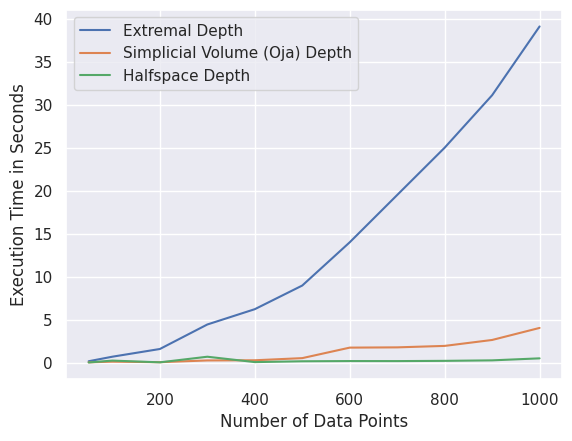

time: 428 ms (started: 2023-11-04 18:02:36 +00:00)


In [ ]:
plt.plot(e_x,e_y)
plt.plot(sv_x,sv_y)
plt.plot(hs_x,hs_y)
plt.legend(['Extremal Depth','Simplicial Volume (Oja) Depth', 'Halfspace Depth'])
plt.xlabel("Number of Data Points")
plt.ylabel("Execution Time in Seconds")
#plt.yscale("log")
plt.show()